In [2]:
import os
import math
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from skimage import io
from skimage.morphology import extrema
from skimage.measure import label

import skimage

import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from scipy import misc

import imageio




import javabridge 
import bioformats
javabridge.start_vm(class_path=bioformats.JARS, max_heap_size='8G')

#import net.imageJ.ImageJ

import xml.etree.cElementTree as ET

import sys
import time


In [3]:
# See your current version of python/anaconda
print (sys.version)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]


In [4]:
"""
Steps Required:

D Look through images

D See if there is an associated text file

D If there is, read in the ROIs

D Convert the string into an array

Associate the ROIs with the image

Convert them into the appropriate form (For YOLO training) 

Export the text files in another directory

Export the images (triple versions of the first channel for now) into a seperate directory



Next Steps:

Subsegment the image into appropriate sizes

Reassign ROIs to fit the new classes

Make sure the new image files do not cut through too many ROIs





"""

'\nSteps Required:\n\nD Look through images\n\nD See if there is an associated text file\n\nD If there is, read in the ROIs\n\nD Convert the string into an array\n\nAssociate the ROIs with the image\n\nConvert them into the appropriate form (For YOLO training) \n\nExport the text files in another directory\n\nExport the images (triple versions of the first channel for now) into a seperate directory\n\n\n\nNext Steps:\n\nSubsegment the image into appropriate sizes\n\nReassign ROIs to fit the new classes\n\nMake sure the new image files do not cut through too many ROIs\n\n\n\n\n\n'

In [5]:
class ImageParams():
    def __init__(self, directory, filename, channel_array, image_type_array, channel_thresholds):
        self.directory = directory 
        self.filename = filename
        self.file_path = (f'{directory}{os.sep}{filename}')

        
        
        self.dir_name = directory.replace(os.path.dirname(directory), "")
        self.upper_dir_name = os.path.dirname(directory).replace (os.path.dirname(os.path.dirname(directory)), "")[1:]
        
        self.ROI_list = []
        
        
        image = Image.open(self.file_path)
        self.total_frames = image.n_frames
        self.width = image.width
        self.length = image.height
        
        self.channel_array = channel_array
        self.image_type_array = image_type_array
        
        self.channel_thresholds = channel_thresholds
        
        assert (len(channel_array) == len(image_type_array)), "Anisotropy and Channel arrays are not of equal length"
              
        self.channel_offset = np.zeros(len(channel_array))
        
        images_per_timepoint = 0
        for index, items in enumerate(channel_array):
            #print (index, items, images_per_timepoint)
            self.channel_offset[index] = images_per_timepoint
            images_per_timepoint += items
        
        self.images_per_timepoint = images_per_timepoint
        self.timepoints = self.total_frames // images_per_timepoint
        

In [6]:
def find_files(path, directory_list = {}):
    all_files = os.listdir(path)
    #print (all_files)
    for files in all_files:
        #print (path, os.path.dirname(path))
        
        #When you find the appropriate file, add the directory to the dictionary for processing
        if os.path.isfile(f'{path}{os.sep}{files}'):
            #print ("Found a file")
            if files.endswith("ome.tif"):
                #print (f"Ends with ome.tif ({files})")
                prev_directory = os.path.dirname(path)
                current_directory = path.replace(prev_directory, "")
                if prev_directory in directory_list:
                    directory_list[prev_directory][current_directory] = None
                                    
                else:
                    directory_list[prev_directory] = {current_directory : None}
                
                
                
        elif os.path.isdir(f'{path}{os.sep}{files}'):
            directory_list = find_files(f'{path}{os.sep}{files}', directory_list)
            #print ("Found a directory")
    
    
    return (directory_list)

In [28]:
def iterate_through_files(directory_list, Parameters, dataframes = []):
    """
    The purpose of this function is to iterate through all of the files in the directory list and analyze
        the relevant files.
        
        
    Input:
    directory_list is a dictionary of root directories containing dictionaries of subdirectories
        In most cases, there will be one subdirectory per root_directory, however this may not
        always be the case
    
    
    Parameters - the overall imaging parameters passed through to the analysis
        .suffix - the suffix used to identify images of interest
    
    
    dataframes - the list of dataframes. In most cases, you will be creating a new one
    
    
    """ 

  
    
    for root_dir in directory_list:
        #note: there will usually only be one subdirectory per root_dir
        annotation_dir = f'{root_dir}Annotations'
        image_dir = f'{root_dir}JPEGImages'
        
        for directories in directory_list[root_dir]:
            #print (os.path.dirname(os.path.dirname(directories)))
            file_list = os.listdir(f'{root_dir}{directories}')
            for files in file_list:
                if files.endswith(".ome.tif"):
                    #print (files)
                    
                    #print ("Iterating through files...")
                    
                    
                    ROIs = read_ROI_File(f'{root_dir}{directories}{os.sep}{files}')
                    #Process the image if there is an associated ROI file
                    #print (ROIs)
                    if (not ROIs.empty):
                        ROIs = process_ROI_dataframe(ROIs)
                        #output_labels(None, ROIs, f'{root_dir}{directories}{os.sep}{files}')
                        segment_image(None, ROIs, root_dir, directories, files)
                        
                    
                    
                    
                    
                    
                    #Analyze the image
                    #dataframes = image_Analysis(current_Image, Parameters = Parameters, dataframes = dataframes)
                                     
   



            
   
    
    return (dataframes)
            

In [90]:
def segment_image(Parameters, ROIs, root_dir, sub_dir, filename):
    
    print (root_dir, sub_dir, filename)
    print("Segmenting image.... :)")
    
    #Parameters
    subimage_height = 370 
    subimage_width = 632 #or 316
    
    
    filepath = f'{root_dir}{sub_dir}{os.sep}{filename}'
    annotations_dir = f'{root_dir}{os.sep}Annotations{sub_dir}'
    image_dir = f'{root_dir}{os.sep}JPEGImages{sub_dir}'
    
    for dirs in [annotations_dir, image_dir]:
        if (not os.path.isdir(dirs)):
            os.makedirs(dirs)
    
    
    #Preprocess the image
    image_open = np.asarray(bioformats.load_image(filepath, c = 0, z=0, t=3, rescale=False))
    image_para = np.asarray(bioformats.load_image(filepath, c = 0, z=0, t=4, rescale=False))
    image_perp = np.asarray(bioformats.load_image(filepath, c = 0, z=0, t=5, rescale=False))
    
    img = np.dstack([image_open, image_para, image_perp])
    img = img/np.amax(img)
        
    img = img*255
    img = img.astype('uint8')
    plt.imshow(img)
    
    
    print ("Shape", img.shape)
    
    height, width, depth = img.shape
    print (ROIs)
    
    
    
    #make the subimages - images should be within 
    for i in range (height//subimage_height):
        for j in range (width//subimage_width):
            xmin = i*subimage_height
            xmax = (i+1)*subimage_height
            ymin = j*subimage_width
            ymax = (j+1)*subimage_width
            
            
            
            subimage = img[xmin:xmax, ymin:ymax, :]
            
            
            subROIs = ROIs[(ROIs['X']>xmin) & 
                           (ROIs['X']<xmax) & 
                           (ROIs['Y']>ymin) & 
                           (ROIs['Y']<ymax)].copy()
            
            
            

            
            
            
            #If ROI list is not empty           
            if len(subROIs)>0:
                
                #mod ROIs to fit the new size
                subROIs['xmin'] = subROIs['xmin'] - xmin
                subROIs['xmax'] = subROIs['xmax'] - xmin
                subROIs['ymin'] = subROIs['ymin'] - ymin
                subROIs['ymax'] = subROIs['ymax'] - ymin
                
                #Check for any truncations
                subROIs['Truncated'] = ((subROIs['xmin']<0) | (subROIs['xmax']>xmax) | 
                                        (subROIs['ymin']<0) | (subROIs['ymax']>ymax))
                
                
                
                
                #print (i, j, xmin, xmax, ymin, ymax, len(subROIs))
                print (subROIs)
                #Save the jpeg files
                imageio.imwrite(f'{image_dir}{os.sep}{filename}'.replace('.ome.tif', f'{i}{j}.jpg' ), subimage)
                #Output the labels
                
               
                
                
                output_filename = f'{root_dir}{os.sep}Annotations{sub_dir}{os.sep}{filename}'.replace(".ome.tif", f"{i}{j}--labels.xml")
                
                labels = {'Height': subimage.shape[1], 
                          'Width': subimage.shape[0], 
                          'Filename' : (f'{filename}'.replace('.ome.tif', f'{i}{j}.jpg')) , 'Folder': f'{sub_dir}'[1:]}          
                
                output_labels (labels, subROIs, output_filename)
            
            
    

    
    
    
    
    
    

    #Save the jpeg files
    #imageio.imwrite(f'{image_dir}{os.sep}{filename}'.replace('.ome.tif', '.jpg' ), img)
    
    
    
    #Output the labels
    #output_filename = f'{root_dir}{os.sep}Annotations{sub_dir}{os.sep}{filename}'.replace(".ome.tif", "--labels.xml")
    #print (output_filename)
    #output_labels (Parameters, ROIs, output_filename)
    
    
    return(None)

C:\Users\William\Desktop\Box Testing Baseline\Baseline_1\Baseline_1_MMStack_1-Pos_000_000--labels.txt
Exists
C:\Users\William\Desktop\Box Testing Baseline\Baseline_1\Baseline_1_MMStack_1-Pos_000_000.ome.tif
C:\Users\William\Desktop\Box Testing Baseline \Baseline_1 Baseline_1_MMStack_1-Pos_000_000.ome.tif
Segmenting image.... :)
Shape (1480, 2528, 3)
   Class       Y       X      H      W    xmin    xmax    ymin    ymax
0    1.0  1478.0   601.0  204.0  202.0   500.0   702.0  1376.0  1580.0
1    1.0  1780.0   640.5  240.0  271.0   505.0   776.0  1660.0  1900.0
2    1.0  2031.0   213.0  182.0  264.0    81.0   345.0  1940.0  2122.0
3    1.0   594.5   945.5  219.0  161.0   865.0  1026.0   485.0   704.0
4    1.0   697.0  1116.0  168.0  124.0  1054.0  1178.0   613.0   781.0
5    1.0   312.0  1359.0  144.0  124.0  1297.0  1421.0   240.0   384.0
6    1.0   434.0  1378.5  196.0  125.0  1316.0  1441.0   336.0   532.0
   Class       Y      X      H      W  xmin   xmax  ymin   ymax  Truncated
2    

Shape (1480, 2528, 3)
    Class       Y       X      H      W    xmin    xmax    ymin    ymax
0     1.0   779.0   849.0  218.0  126.0   786.0   912.0   670.0   888.0
1     1.0   331.0   641.5  186.0  169.0   557.0   726.0   238.0   424.0
2     1.0   101.0   601.0  144.0  130.0   536.0   666.0    29.0   173.0
3     1.0   840.5   211.0  143.0  122.0   150.0   272.0   769.0   912.0
4     1.0  1191.5   156.0  131.0  124.0    94.0   218.0  1126.0  1257.0
5     1.0  1351.0  1291.0  146.0  138.0  1222.0  1360.0  1278.0  1424.0
6     1.0  1331.5  1427.0  149.0  106.0  1374.0  1480.0  1257.0  1406.0
7     1.0  1532.0  1413.0  144.0  134.0  1346.0  1480.0  1460.0  1604.0
8     1.0  2099.0  1297.0  132.0  126.0  1234.0  1360.0  2033.0  2165.0
9     1.0   239.0  1164.0  150.0  132.0  1098.0  1230.0   164.0   314.0
10    1.0   582.5   185.0  115.0  126.0   122.0   248.0   525.0   640.0
    Class      Y      X      H      W   xmin   xmax   ymin   ymax  Truncated
10    1.0  582.5  185.0  115.0  126.0

Shape (1480, 2528, 3)
   Class       Y       X      H      W    xmin    xmax    ymin    ymax
0    1.0   462.5  1201.5  179.0  135.0  1134.0  1269.0   373.0   552.0
1    1.0  2010.5   842.0  141.0  156.0   764.0   920.0  1940.0  2081.0
2    1.0  1450.0   658.5  164.0  173.0   572.0   745.0  1368.0  1532.0
3    1.0  1477.0  1241.0  182.0  126.0  1178.0  1304.0  1386.0  1568.0
4    1.0    40.0   185.0   80.0  126.0   122.0   248.0     0.0    80.0
5    1.0   351.5   883.5  131.0  133.0   817.0   950.0   286.0   417.0
   Class     Y      X     H      W   xmin   xmax  ymin  ymax  Truncated
4    1.0  40.0  185.0  80.0  126.0  122.0  248.0   0.0  80.0      False
Object count is 1
   Class       Y      X      H      W   xmin   xmax   ymin   ymax  Truncated
2    1.0  1450.0  658.5  164.0  173.0  202.0  375.0  104.0  268.0      False
Object count is 1
   Class      Y      X      H      W  xmin   xmax   ymin   ymax  Truncated
5    1.0  351.5  883.5  131.0  133.0  77.0  210.0  286.0  417.0      Fal

Shape (1480, 2528, 3)
   Class      Y       X      H      W    xmin    xmax   ymin   ymax
0    1.0  536.0   856.0  128.0  148.0   782.0   930.0  472.0  600.0
1    1.0  265.0   895.0  174.0  118.0   836.0   954.0  178.0  352.0
2    1.0  335.0  1095.5  186.0  123.0  1034.0  1157.0  242.0  428.0
   Class      Y       X      H      W   xmin   xmax   ymin   ymax  Truncated
0    1.0  536.0   856.0  128.0  148.0   42.0  190.0  472.0  600.0      False
1    1.0  265.0   895.0  174.0  118.0   96.0  214.0  178.0  352.0      False
2    1.0  335.0  1095.5  186.0  123.0  294.0  417.0  242.0  428.0      False
Object count is 3
C:\Users\William\Desktop\Box Testing Baseline\Baseline_1\Baseline_1_MMStack_1-Pos_003_004--labels.txt
Exists
C:\Users\William\Desktop\Box Testing Baseline\Baseline_1\Baseline_1_MMStack_1-Pos_003_004.ome.tif
C:\Users\William\Desktop\Box Testing Baseline \Baseline_1 Baseline_1_MMStack_1-Pos_003_004.ome.tif
Segmenting image.... :)
Shape (1480, 2528, 3)
   Class       Y      X     

Shape (1480, 2528, 3)
   Class       Y      X      H      W   xmin   xmax    ymin    ymax
0    1.0  1173.0  281.5  150.0  113.0  225.0  338.0  1098.0  1248.0
1    1.0  1346.5  343.0  149.0  146.0  270.0  416.0  1272.0  1421.0
   Class       Y      X      H      W   xmin   xmax   ymin   ymax  Truncated
0    1.0  1173.0  281.5  150.0  113.0  225.0  338.0  466.0  616.0      False
Object count is 1
   Class       Y      X      H      W   xmin   xmax  ymin   ymax  Truncated
1    1.0  1346.5  343.0  149.0  146.0  270.0  416.0   8.0  157.0       True
Object count is 1


[]

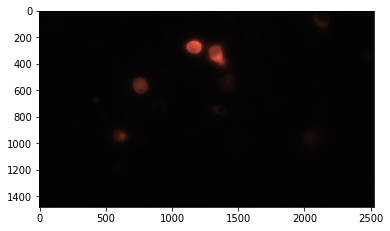

In [91]:
#directory = f'D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Box Testing Baseline'
directory = f'C:{os.sep}Users{os.sep}William{os.sep}Desktop{os.sep}Box Testing Baseline'
all_files = find_files(directory)
iterate_through_files(all_files, None)

In [11]:
def process_ROI_dataframe(ROIs):    
    
    
    #Switch X and Y for python standards
    
    ROIs = ROIs.rename(columns={'X':'Y', 'Y':'X'})
    
    ROIs['xmin'] = ROIs['X'] - ROIs['W']/2
    ROIs['xmax'] = ROIs['X'] + ROIs['W']/2
    ROIs['ymin'] = ROIs['Y'] - ROIs['H']/2
    ROIs['ymax'] = ROIs['Y'] + ROIs['H']/2
    
    
    
    
    #print (ROIs)
    
    return (ROIs)

In [81]:
def output_labels(Labels, ROIs, filepath):
    
    
    """
    Outputs the text labels into the VOC Pascal format for Lightnet to use
    
    Inputs:
    Filename
    ROIs - List of ROIs used to 
       
    
    
    
    """
    output_path = filepath

    objects = ['aeroplace', 'cat']
    
    
    annotation = ET.Element('annotation')
    tree = ET.ElementTree(annotation)


    folder = ET.SubElement(annotation, 'folder')
    folder.text = Labels['Folder']
    
    filename = ET.SubElement(annotation, 'filename')
    filename.text = Labels['Filename']

    source = ET.SubElement(annotation, 'source')
    source_database = ET.SubElement(source, 'database')
    source_annotation = ET.SubElement(source, 'annotation')
    source_image = ET.SubElement(source, 'image')
    source_flickrid = ET.SubElement(source, 'flickrid')

    owner = ET.SubElement(annotation, 'owner')
    owner_flickrid = ET.SubElement(owner, 'flickrid')

    
    
    object_subelements = ['name', 'pose', 'truncated', 'difficult', 'bndbox']
    bndbox_subelements = ['xmin', 'ymin', 'xmax', 'ymax']
    
    
    
    
    

    object_count = len(ROIs)
    print ("Object count is", object_count)
    Objects = []


    for i in ROIs.index:
        dictionary = {}

        dictionary['object'] = ET.SubElement(annotation, 'object')


        dictionary['name'] = ET.SubElement(dictionary['object'], 'name')
        dictionary['name'].text = str(objects[int(ROIs.loc[i, 'Class'])])
        dictionary['pose'] = ET.SubElement(dictionary['object'], 'pose')
        dictionary['truncated'] = ET.SubElement(dictionary['object'], 'truncated')
        dictionary['difficult'] = ET.SubElement(dictionary['object'], 'difficult')
        dictionary['bndbox'] = ET.SubElement(dictionary['object'], 'bndbox')

        dictionary['bndbox'].tail = '\n'
        
        
        
        
        
        for element in bndbox_subelements:
            dictionary[element] = ET.SubElement(dictionary['bndbox'], element)
            dictionary[element].text = str(int(ROIs.loc[i, element]))
        
        
        
        

        Objects.append (dictionary)



    tree.write(output_path)
    
    return (None)



In [82]:
def save_image(filepath, output_path):
    
    image_open = np.asarray(bioformats.load_image(filepath, c = 0, z=0, t=3, rescale=False))
    image_para = np.asarray(bioformats.load_image(filepath, c = 0, z=0, t=4, rescale=False))
    image_perp = np.asarray(bioformats.load_image(filepath, c = 0, z=0, t=5, rescale=False))
    
    image2 = np.dstack([image_open, image_para, image_perp])
    image2 = image2/np.amax(image2)
        
    img = image2*255
    img = img.astype('uint8')
    print (np.amax(img))
    #img = Image.fromarray(image2, 'RGB')
    print (type (img))
    plt.imshow(img)
    outpath = "D:/Documents/Documents/0000 New Scope/Box Testing Baseline/Baseline_1/Baseline_1_MMStack_1-Pos_000_000BBB.ome.jpg"
    
    
    imageio.imwrite(outpath, img)
    #cv2.imwrite(outpath, img)
    #img.save(outpath, 'JPEG')
    
    
    
    return (None)

In [14]:
save_image (path, outpath)

NameError: name 'path' is not defined

In [162]:
labels = {'Hello':4, 'Pizza':7}
print (labels['Hello'])

4


In [91]:
def split_image (image, ROIs):
    
    
    
    #split the image
    #Reprocess the ROIs
    
    #Save both image and ROIs
    
    
    #
    
    
    
    return (None)

In [92]:
dff = pd.DataFrame()
print (len(dff))

0


In [15]:
def process_ROIs():
    
    
    
    
    
    
    
    return (ROIList)

In [16]:
def read_ROI_File(filepath):
    
    text_path = filepath.replace(".ome.tif", "--labels.txt")
    print (text_path)
    
    if os.path.isfile(text_path):
        print ("Exists")
        ROI_List = pd.read_csv(text_path, index_col = False)
        #print (ROI_List)
        
        
    else:
        print ("No ROI File")
        ROI_List = pd.DataFrame()
    
    print (filepath)


    
    
    
    
    #except:
    #    ROI_List = None
    
    
    return (ROI_List)

In [225]:
path = "D:/Documents/Documents/0000 New Scope/Box Testing Baseline/Baseline_1/Baseline_1_MMStack_1-Pos_000_000--labels.txt"

with open (path, 'r', encoding = "latin-1") as file:
            for line in file:
                print (line)
                
                
series = pd.read_csv(path, index_col = False)
print (len(series))
series = series.rename(columns = {'X':'Y', 'Y': 'X'})
#series


print (series.loc[2, 'H'])
series

Class,X,Y,H,W

1.00,1478.00,601.00,204.00,202.00,

1.00,1780.00,640.50,240.00,271.00,

1.00,2031.00,213.00,182.00,264.00,

1.00,594.50,945.50,219.00,161.00,

1.00,697.00,1116.00,168.00,124.00,

1.00,312.00,1359.00,144.00,124.00,

1.00,434.00,1378.50,196.00,125.00,

7
182.0


,Class,Y,X,H,W
0,1.0,1478.0,601.0,204.0,202.0
1,1.0,1780.0,640.5,240.0,271.0
2,1.0,2031.0,213.0,182.0,264.0
3,1.0,594.5,945.5,219.0,161.0
4,1.0,697.0,1116.0,168.0,124.0
5,1.0,312.0,1359.0,144.0,124.0
6,1.0,434.0,1378.5,196.0,125.0


In [229]:
series['Truncated'] = ((series['X']>500) | (series['Y']<1200))
series

,Class,Y,X,H,W,Truncated
0,1.0,1478.0,601.0,204.0,202.0,True
1,1.0,1780.0,640.5,240.0,271.0,True
2,1.0,2031.0,213.0,182.0,264.0,False
3,1.0,594.5,945.5,219.0,161.0,True
4,1.0,697.0,1116.0,168.0,124.0,True
5,1.0,312.0,1359.0,144.0,124.0,True
6,1.0,434.0,1378.5,196.0,125.0,True


In [185]:
subb = series[(series['X']<1000) & (series['Y']<1200)]

In [186]:
subb.index

Int64Index([3, 4], dtype='int64')

D:\Documents\Documents\0000 New Scope\Box Testing Baseline\Baseline_1\Baseline_1_MMStack_1-Pos_000_000--labels.txt
Exists
D:\Documents\Documents\0000 New Scope\Box Testing Baseline\Baseline_1\Baseline_1_MMStack_1-Pos_000_000.ome.tif
D:\Documents\Documents\0000 New Scope\Box Testing Baseline \Baseline_1 Baseline_1_MMStack_1-Pos_000_000.ome.tif
Segmenting image.... :)
Shape (1480, 2528, 3)
   Class       Y       X      H      W    xmin    xmax    ymin    ymax
0    1.0  1478.0   601.0  204.0  202.0   500.0   702.0  1376.0  1580.0
1    1.0  1780.0   640.5  240.0  271.0   505.0   776.0  1660.0  1900.0
2    1.0  2031.0   213.0  182.0  264.0    81.0   345.0  1940.0  2122.0
3    1.0   594.5   945.5  219.0  161.0   865.0  1026.0   485.0   704.0
4    1.0   697.0  1116.0  168.0  124.0  1054.0  1178.0   613.0   781.0
5    1.0   312.0  1359.0  144.0  124.0  1297.0  1421.0   240.0   384.0
6    1.0   434.0  1378.5  196.0  125.0  1316.0  1441.0   336.0   532.0
   Class       Y      X      H      W  xm

[]

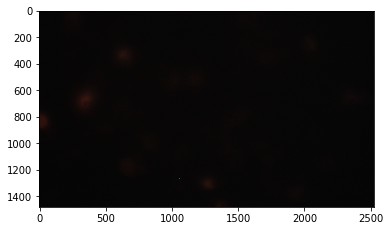

In [217]:
directory = f'D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Box Testing Baseline'

all_files = find_files(directory)
iterate_through_files(all_files, None)

In [ ]:
import pickle

In [ ]:
path = "C:/Users/William/Desktop/Lightnet/examples/yolo-voc/data/train.pkl"

In [ ]:
ROI_List = pd.read_csv("D:/Documents/Documents/0000 New Scope/Box Testing Baseline/Baseline_1/Baseline_1_MMStack_1-Pos_000_000--labels.txt")

In [92]:
#Create the pickle file...

import os
import sys
import xml.etree.ElementTree as ET
import brambox.boxes as bbb

DEBUG = True        # Enable some debug prints with extra information
ROOT = '../data'    # Root folder where the VOCdevkit is located

ROOT = f'C:{os.sep}Users{os.sep}William{os.sep}Desktop{os.sep}Box Testing Baseline'

TRAINSET = [
    ('2012', 'train'),
    ('2012', 'val'),
    ('2007', 'train'),
    ('2007', 'val'),
    ]
TESTSET = [
    ('2007', 'test'),
    ]


def identify(xml_file):
    root = ET.parse(xml_file).getroot()
    folder = root.find('folder').text
    filename = os.path.splitext(root.find('filename').text)[0]
    #return f'{folder}/JPEGImages/{filename}'
    return f'{folder}{os.sep}{filename}'


if __name__ == '__main__':
    
    #find all files for the training set...
    print('Getting training annotation filenames')
    train = []
    
    """for (year, img_set) in TRAINSET:
        with open(f'{ROOT}/VOCdevkit/VOC{year}/ImageSets/Main/{img_set}.txt', 'r') as f:
            ids = f.read().strip().split()
        train += [f'{ROOT}/VOCdevkit/VOC{year}/Annotations/{xml_id}.xml' for xml_id in ids]
    """
    
    anno_directory = f"C:{os.sep}Users{os.sep}William{os.sep}Desktop{os.sep}Box Testing Baseline{os.sep}Annotations{os.sep}Baseline_1"
    anno_list = os.listdir(anno_directory)
    anno_list = [x for x in anno_list if x.endswith('.xml')]
    train = [f'{anno_directory}{os.sep}{x}' for x in anno_list]
    
        
    
        
    if DEBUG:
        print(f'\t{len(train)} xml files')

    print('Parsing training annotation files')
    #train_annos = bbb.parse('anno_pascalvoc', train, identify)
    train_annos = bbb.parse('anno_pascalvoc', train, identify)
    
    
    # Remove difficult for training
    for k,annos in train_annos.items():
        for i in range(len(annos)-1, -1, -1):
            if annos[i].difficult:
                del annos[i]

    print('Generating training annotation file')
    bbb.generate('anno_pickle', train_annos, f'{ROOT}/train.pkl')

    print()

    """
    print('Getting testing annotation filenames')
    test = []
    for (year, img_set) in TESTSET:
        with open(f'{ROOT}/VOCdevkit/VOC{year}/ImageSets/Main/{img_set}.txt', 'r') as f:
            ids = f.read().strip().split()
        test += [f'{ROOT}/VOCdevkit/VOC{year}/Annotations/{xml_id}.xml' for xml_id in ids]

    if DEBUG:
        print(f'\t{len(test)} xml files')

    print('Parsing testing annotation files')
    test_annos = bbb.parse('anno_pascalvoc', test, identify)

    print('Generating testing annotation file')
    bbb.generate('anno_pickle', test_annos, f'{ROOT}/test.pkl')
"""

INFO       [brambox.boxes.annotations.pickle] No 'keep_ignore' kwarg found, defaulting to False.


Getting training annotation filenames
	96 xml files
Parsing training annotation files
Generating training annotation file



In [85]:
train_annos

{'C:\\Users\\William\\Desktop\\Box Testing Baseline\\Baseline_1\\Baseline_1_MMStack_1-Pos_000_00003': [PascalVocAnnotation {class_label = 'cat', object_id = None, x = 81.0, y = 44.0, w = 265.0, h = 183.0, ignore = False, lost = False, difficult = False, truncated_fraction = 0.0, occluded_fraction = 0.0, visible_x = 0.0, visible_y = 0.0, visible_w = 0.0, visible_h = 0.0}],
 'C:\\Users\\William\\Desktop\\Box Testing Baseline\\Baseline_1\\Baseline_1_MMStack_1-Pos_000_00012': [PascalVocAnnotation {class_label = 'cat', object_id = None, x = 130.0, y = 112.0, w = 203.0, h = 205.0, ignore = False, lost = False, difficult = False, truncated_fraction = 0.0, occluded_fraction = 0.0, visible_x = 0.0, visible_y = 0.0, visible_w = 0.0, visible_h = 0.0},
  PascalVocAnnotation {class_label = 'cat', object_id = None, x = 135.0, y = 396.0, w = 272.0, h = 241.0, ignore = False, lost = False, difficult = False, truncated_fraction = 0.0, occluded_fraction = 0.0, visible_x = 0.0, visible_y = 0.0, visible_w

In [47]:
anno_directory = f"C:{os.sep}Users{os.sep}William{os.sep}Desktop{os.sep}Box Testing Baseline{os.sep}Annotations"
anno_list = os.listdir(anno_directory)
anno_list = [x for x in anno_list if x.endswith('.xml')]
anno_merge = [f'{anno_directory}{os.sep}{x}' for x in anno_list]

['Baseline_1_MMStack_1-Pos_000_00003--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00012--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00020--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00030--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00031--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00101--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00103--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00110--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00112--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00113--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00122--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00123--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00133--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00201--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00212--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00222--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00231--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00232--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_00233--labels.xml',
 'Baseline_1_MMStack_1-Pos_000_

['C:\\Users\\William\\Desktop\\Box Testing Baseline\\Annotations\\Baseline_1_MMStack_1-Pos_000_00003--labels.xml',
 'C:\\Users\\William\\Desktop\\Box Testing Baseline\\Annotations\\Baseline_1_MMStack_1-Pos_000_00012--labels.xml',
 'C:\\Users\\William\\Desktop\\Box Testing Baseline\\Annotations\\Baseline_1_MMStack_1-Pos_000_00020--labels.xml',
 'C:\\Users\\William\\Desktop\\Box Testing Baseline\\Annotations\\Baseline_1_MMStack_1-Pos_000_00030--labels.xml',
 'C:\\Users\\William\\Desktop\\Box Testing Baseline\\Annotations\\Baseline_1_MMStack_1-Pos_000_00031--labels.xml',
 'C:\\Users\\William\\Desktop\\Box Testing Baseline\\Annotations\\Baseline_1_MMStack_1-Pos_000_00101--labels.xml',
 'C:\\Users\\William\\Desktop\\Box Testing Baseline\\Annotations\\Baseline_1_MMStack_1-Pos_000_00103--labels.xml',
 'C:\\Users\\William\\Desktop\\Box Testing Baseline\\Annotations\\Baseline_1_MMStack_1-Pos_000_00110--labels.xml',
 'C:\\Users\\William\\Desktop\\Box Testing Baseline\\Annotations\\Baseline_1_MMS

In [40]:
print (anno_list)

['Baseline_1_MMStack_1-Pos_000_00003--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00012--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00020--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00030--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00031--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00101--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00103--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00110--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00112--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00113--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00122--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00123--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00133--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00201--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00212--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00222--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00231--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00232--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00233--labels.xml', 'Baseline_1_MMStack_1-Pos_000_00301--labels.xml',

In [ ]:
class ImagingParameters():
    def __init__(self, NA, index_of_refraction, mag, gFactor, 
                 debug_mode, channel_array, image_type_array, 
                 channel_thresholds, 
                 timepoints = 1, same_cells = False, 
                 max_filter_region = 5, max_threshold =  600,
                 root_dir_same_treatment = True, suffix = "ome.tif"):
        
        self.NA = NA
        self.index_of_refraction = index_of_refraction
        self.mag = mag
        self.gFactor = gFactor
        self.debug_mode = debug_mode
        self.channel_array = channel_array
        self.image_type_array = image_type_array
        self.max_filter_region = max_filter_region
        self.max_threhsold = max_threshold
        self.root_dir_same_treatment = root_dir_same_treatment
        self.suffix = suffix
        self.channel_thresholds = channel_thresholds
        
        subframes = 0
        for items in channel_array:
            subframes += items
            
        self.frames_per_timepoint = subframes
        
        asin = math.asin(NA/index_of_refraction) 
        cos = math.cos(asin)
        
        kA = (2.0 - 3.0 * cos + cos * cos * cos) / (6.0 * (1.0 - cos))
        kB = (1.0 - 3.0 * cos + 3.0 * cos * cos - cos * cos * cos) / (24.0 * (1.0 - cos))
        kC = (5.0 - 3.0 * cos - cos * cos - cos * cos * cos) / (8.0 * (1.0 - cos))
        dddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd
        
        self.kA = kA
        self.kB = kB
        self.kC = kC
        
        print (kA, kB, kC)
        
        """
                double Ka = (2.0 - 3.0 * d2 + d2 * d2 * d2) / (6.0 * (1.0 - d2));
        double Kb = (1.0 - 3.0 * d2 + 3.0 * d2 * d2 - d2 * d2 * d2) / (24.0 * (1.0 - d2));
        double Kc = (5.0 - 3.0 * d2 - d2 * d2 - d2 * d2 * d2) / (8.0 * (1.0 - d2));"""

In [ ]:
class ROIs():
    def __init__(self, x, y, data):
        self.x = x
        self.y = y
        self.data = data
        
        y_length, x_length = data.shape
        
        self.x_length = x_length
        self.y_length = y_length

In [ ]:
#Future Development: Use settings files

"""
Initialize the plugin.  The user variables are all listed here

path: directory where the images are stored
background_subtractions: {automatic, manual, none}
Channels structure: 
Anisotropy Structure:

debug_mode: whether you want all of the images to output

"""
## This should be a text file that's imported (change newlines to commas and imput it into parameters)
numerical_aperture = 1.4
index_of_refraction = 1.53
magnification = 63
gFactor = 1.0
debug_mode = True
channel_array = [3,3,1]
image_type_array = ["Anisotropy","Intensity","Brightfield"]
channel_thresholds = [500, 500, 500]
same_cells = True
max_filter_region = 40
max_threshold =  800
root_dir_same_treatment = True
suffix = "ome.tif"


Parameters = ImagingParameters(NA = numerical_aperture,
                               index_of_refraction = index_of_refraction,
                               mag = magnification, 
                               gFactor = gFactor,
                               debug_mode = debug_mode,
                               channel_array = channel_array,
                               channel_thresholds = channel_thresholds,
                               image_type_array = image_type_array,
                               max_filter_region = max_filter_region,
                               max_threshold=max_threshold,
                               root_dir_same_treatment = root_dir_same_treatment,
                               suffix = suffix)
                               



In [ ]:
#@ImageJ ij

In [ ]:
def find_files(path, directory_list = {}):
    all_files = os.listdir(path)
    #print (all_files)
    for files in all_files:
        #print (path, os.path.dirname(path))
        
        #When you find the appropriate file, add the directory to the dictionary for processing
        if os.path.isfile(f'{path}{os.sep}{files}'):
            #print ("Found a file")
            if files.endswith("ome.tif"):
                #print (f"Ends with ome.tif ({files})")
                prev_directory = os.path.dirname(path)
                current_directory = path.replace(prev_directory, "")
                if prev_directory in directory_list:
                    directory_list[prev_directory][current_directory] = None
                                    
                else:
                    directory_list[prev_directory] = {current_directory : None}
                
                
                
        elif os.path.isdir(f'{path}{os.sep}{files}'):
            directory_list = find_files(f'{path}{os.sep}{files}', directory_list)
            #print ("Found a directory")
    
    
    return (directory_list)

In [ ]:
def calculate_anisotropy(image, Parameters):
    """
    Parameters contains:
        NA - Numerical Aperture
        index_of_refraction - Index of Refraction for the immersion media
        mag - Magnification
        gFactor - G-Factor for the detector
        
        kA - Correctional Factors for high NA
        kB - Correctional Factors for high NA
        kC - Correctional Factors for high NA
        
        
    image.shape[-1] should be equal to 3 with channels: Open, Parallel, Perpendicular
    """
    
    
    Ka = Parameters.kA
    Kb = Parameters.kB
    Kc = Parameters.kC
    
    
    G = Parameters.gFactor
    
    
    anisotropy_image = np.zeros((image.shape))
    
    #print (f'Ka: {Ka}, Kb: {Kb}, Kc: {Kc}, G: {G}')
    
    #Change to image class
    Para = image[:,:,1]
    Perp = image[:,:,2]
    

    
    Ix = ((Kb * Para - Kc * Perp*G)/(Ka*Kb + Kb**2 -Ka*Kc - Kc**2))
    Iy = ((((Ka + Kb) * Perp*G) - (Ka+Kc)*Para)/(Ka*Kb+Kb**2-Ka*Kc-Kc**2))
    
    
    #print (Para)
    #print (Iy)
    
    anisotropy_image[:,:,0] = Iy
    anisotropy_image[:,:,1] = Ix
    anisotropy_image[:,:,2] = 0
    
    
    

    numerator = np.add(Iy, np.multiply(Ix, -2*G))
    
    denominator = np.add(Iy, np.multiply(Ix, 2*G))
    
    
    #print (numerator)
    #print (denominator)
    
    anisotropy_image[:,:,-1] = np.divide (numerator, denominator, where=denominator!=0)
    #anisotropy_image[:,:,2] = np.divide((np.add(Iy, np.multiply(Ix, -2*G))),(np.add(Iy, np.multiply(Ix, 2*G)))) 
    
    
    
    return (anisotropy_image)

In [ ]:
def create_pd_dataframe():
    
    dataframe = pd.DataFrame(columns=[(-1, -1,  "Image"), (-1,-1,"Index"), (-1, -1, "ROI")])
    #dataframe = pd.DataFrame(columns=["Image", "Index", "ROI"])
        
    
    return (dataframe)

In [ ]:
create_pd_dataframe().head()

In [ ]:
def iterate_through_files(directory_list, Parameters, dataframes = []):
    """
    The purpose of this function is to iterate through all of the files in the directory list and analyze
        the relevant files.
        
        
    Input:
    directory_list is a dictionary of root directories containing dictionaries of subdirectories
        In most cases, there will be one subdirectory per root_directory, however this may not
        always be the case
    
    
    Parameters - the overall imaging parameters passed through to the analysis
        .suffix - the suffix used to identify images of interest
    
    
    dataframes - the list of dataframes. In most cases, you will be creating a new one
    
    
    """ 
    
    suffix = Parameters.suffix

    #knowing the previous directory we looked at helps to determine whether we should append the
        #results to a current dataframe or not.  You want to append if the data are from the same cells
    prev_directory = ""
    new_dataframe = True
    
    
    for root_dir in directory_list:
        #note: there will usually only be one subdirectory per root_dir
        for directories in directory_list[root_dir]:
            print (os.path.dirname(os.path.dirname(directories)))
            if os.path.dirname(os.path.dirname(prev_directory)) == os.path.dirname(os.path.dirname(directories)):
                print ("From the same core directory")
                new_dataframe = False
            else:
                print ("Not from the same core directory")
                #if they do not share the same root directory, you need to create a new dataframe
                new_dataframe = True
                dataframes.append({})
            
            
            file_list = os.listdir(f'{root_dir}{directories}')
            for files in file_list:
                if files.endswith(suffix):
                    
                    #store all the relevant information about the image in a new class                    
                    current_Image = ImageParams(f'{root_dir}{directories}',
                                              files, Parameters.channel_array,
                                              Parameters.image_type_array, Parameters.channel_thresholds)
                    
                    #Analyze the image
                    dataframes = image_Analysis(current_Image, Parameters = Parameters, dataframes = dataframes)
                                     
   

            prev_directory = directories

            
            
    
    
    #Append all dataframes (new function?):
    
    for index, _  in enumerate(dataframes):   
        final_dataframe = pd.DataFrame([])
        for filenames in dataframes[index]:
            #print (f"current filename is: {filenames}")
            df_interest = dataframes[index][filenames]
            #print (type(df_interest))
            #print (df_interest)
            if len(final_dataframe)==0:
                #print ("need a new dataframe")
                final_dataframe = df_interest
            else:
                #print ("Appending")
                final_dataframe = final_dataframe.append(df_interest, ignore_index = True, sort = False)


        dataframes[index] = {"Total": final_dataframe}
        #print (final_dataframe)
    
    
    
    
    return (dataframes)                    
                        
                        
                        
                        #bio_im = np.asarray(bioformats.load_image(imageParams.file_path, 
                        #                                          c = 0, z=0, t=offset, rescale=False))
                        #cv2.imshow(str(offset), bio_im)
                        
                    
                    #cv2.waitKey(0)
                    #cv2.destroyAllWindows()
                    
                    #ani_image = calculate_anisotropy (img[0,0:3,:,:], Parameters)
                    #if (Parameters.debug_mode):
                        #cv2.imwrite(f'{root_dir}{directories}{os.sep}{files}2.tiff', ani_image)
                    #print (imageParams.timepoints, imageParams.channel_offset, imageParams.total_frames, files)
    #cv2.destroyAllWindows()
            

In [ ]:
def calc_overlap(ROI1, ROI2, threshold = 0.8):
    """
    
    
    
    """
    x1, y1, x1Len, y1Len = ROI1.x, ROI1.y,  ROI1.x_length, ROI1.y_length
    x2, y2, x2Len, y2Len = ROI2.x, ROI2.y,  ROI2.x_length, ROI2.y_length
    
    
    #print (x1, y1, x1Len, y1Len, x2, y2, x2Len, y2Len)
    
    
    
    box1_Area = (x1Len * y1Len)
    box2_Area = (x2Len * y2Len)
    #print ("b1 Area", box1_Area, "b2 Area", box2_Area)
    
    
    inter_Area = max(0, (min(x1+x1Len, x2+x2Len)-max(x1, x2)))*max(0, (min(y1+y1Len, y2+y2Len) - max(y1, y2)))
    
    
    
    if (box1_Area or box2_Area):
        IoU = inter_Area / (box1_Area + box2_Area - inter_Area + 0.001)
    else:
        IoU = 0
    
    
    
    
    return (IoU) 

In [ ]:
def image_Analysis(current_Image, Parameters, dataframes = []):
    """
    Go through the data file
    
    current_Image:
        directory
        filename
        file_path
        timepoints
        total_frames
        width
        length
        channel_array
        channel_offset
        image_type_array
        images_per_timepoint
        
        dir_name
        upper_dir_name
        
    
    prev_images is a dictionary of all of the most current values from the previous images
        If a cell is found in the first image but not the second, it will still show up in the prev_images for the third image 
    
    
    dataframes is a list of all the dataframes associated with the analysis.
        different groups of data should have different dataframes (aka, data for a different graph)
        
        Dataframes is a list of dictionaries, each containing a dataframe for each image that it is analyzing.
        Once the analysis is complete, the dictionary will be replaced with a single entry dictionary
        {"Total": pd.DataFrame}
    
       
    """
        

        
        
    #g_factor = Parameters.g_factor    

        
    #Import the relevant parameters    
    total_frames = current_Image.total_frames
    timepoints = current_Image.timepoints
    filepath = current_Image.file_path
    filename = current_Image.filename
    channel_offset = current_Image.channel_offset
    image_type_array = current_Image.image_type_array
    images_per_timepoint = current_Image.images_per_timepoint
    upper_dir_name = current_Image.upper_dir_name
    channel_thresholds = current_Image.channel_thresholds
    
    
    #channel_thresholds = current_Ima
    
    
    #Create a new dataframe if required
    #if new_dataframe == True:
    #    print (f"Need to create a new dataframe for:  {filename}")

        
    if filename not in dataframes[-1]:
        new_dataframe = create_pd_dataframe()
        dataframes[-1].update({filename: new_dataframe})
    
    
    current_dataframe = dataframes[-1][filename]
    
    
    all_columns = current_dataframe.columns
    
    master_column_offset = 0
    if len(all_columns)>3:
        master_column_offset = max(all_columns[3:], key = lambda x: x[0])[0] + 1
    
    
    
    
    ROI_match_threshold = 0.4
    
    
    print (f'current image is :{current_Image.filename} in {upper_dir_name} and it has {timepoints} timepoints and length df: {len(dataframes)}')
    for time in range(timepoints):
        for channel, (image_type, offset) in enumerate(zip(image_type_array, channel_offset)):
            #print (f"Current time is: {t}, anisotropy value is {anisotropy} and offset is {offset}")
            total_offset = time * images_per_timepoint + offset
            t = time + master_column_offset
            
            if image_type == "Anisotropy" or image_type == "Intensity":
            
                #Make the new columns:
                
                #pre_string = f'D{upper_dir_name}T{t}C{channel}'
                pre_string = ""
                
                
                para_intensity_str = f'{pre_string}Para'
                perp_intensity_str = f'{pre_string}Perp'
                anipix_intensity_str = f'{pre_string}AniPixel'
                aniavg_intensity_str = f'{pre_string}AniAvg'
                
                intensity_string = "Intensity"
                
                
                
                
                
                

            
                
                
                
                
                
                
                if image_type == "Anisotropy":
                    image_open = np.asarray(bioformats.load_image(filepath, c = 0, z=0, t=total_offset + 0, rescale=False))
                    image_para = np.asarray(bioformats.load_image(filepath, c = 0, z=0, t=total_offset + 1, rescale=False))
                    image_perp = np.asarray(bioformats.load_image(filepath, c = 0, z=0, t=total_offset + 2, rescale=False))

                    raw_image = np.dstack((image_open, image_para, image_perp))
                    anisotropy_image = calculate_anisotropy(raw_image, Parameters)
                    
                    image_for_ROIs = image_open
                    
                    for string in [para_intensity_str, perp_intensity_str,
                                    anipix_intensity_str, aniavg_intensity_str]:
                            current_dataframe[(t, channel, string)] = np.nan
                    
                    
                    
                elif image_type == "Intensity":
                    current_dataframe[(t, channel, intensity_string)] = np.nan
                    image_intensity = np.asarray(bioformats.load_image(filepath, c = 0, z=0, t=total_offset + 0, rescale=False))
                    image_for_ROIs = image_intensity
                    
                    





                
                
                thresholded_image = image_open.copy()
                #if we change to floats, this should be np.nan, which doesn't exist for ints!
                thresholded_image[thresholded_image < channel_thresholds[channel]] = 0
                
                ROI_list = find_ROIs(image_open)


                #anisotropy_analysis(current_Image, dataframes)
            
            

                for ROI in ROI_list:
                    match_index = 0
                    match_IoU = 0
                    for index, compROI in enumerate(current_dataframe[(-1, -1, "ROI")]):
                        #print ("Index is ", index)
                        #print (current_dataframe["ROI"])
                        current_dataframe.head(5)
                        IoU = calc_overlap(ROI, compROI)
                        if (IoU > max(ROI_match_threshold, match_IoU)):
                            match_index = index
                            match_IoU = IoU
                    
                    if match_IoU:
                        #print ("Found a match!!!")
                        row_index = match_index #modify the current value
                        #should also check if there is a value there and append a new result if there is
                        
                        
                    else:
                        #append a new column
                        row_index = len(current_dataframe.index)
                        new_row = pd.DataFrame({(-1, -1, "ROI"): [ROI],
                                                (-1, -1, "Image"): filename,
                                                (-1, -1, "Index"): row_index})
                        current_dataframe = current_dataframe.append(new_row, ignore_index = True, sort=False)

                        #current_dataframe.at[row_index, "ROI"] = ROI

                    
                    
                    x_corner = ROI.x
                    y_corner = ROI.y
                    x_len = ROI.x_length
                    y_len = ROI.y_length
                    
                    
                    
                    ROI_data = {}
                    
                    
                    if image_type == "Anisotropy":


                        para_extract = image_para[y_corner:y_corner+y_len, x_corner: x_corner+x_len].copy()
                        perp_extract = image_perp[y_corner:y_corner+y_len, x_corner: x_corner+x_len].copy()
                        anisotropy_extract = anisotropy_image[y_corner:y_corner+y_len, x_corner: x_corner+x_len, 2].copy()

                        #print ("Shapes", para_extract.shape, ROI.data.shape)
                        #print (x_corner, y_corner, x_len, y_len)

                        para_extract = np.multiply(para_extract, ROI.data)
                        perp_extract = np.multiply(perp_extract, ROI.data)
                        anisotropy_extract = np.multiply(anisotropy_extract, ROI.data)

                        para_value = np.mean(para_extract[para_extract!=0])
                        perp_value = np.mean(perp_extract[para_extract!=0])
                        ani_value = np.mean(anisotropy_extract[para_extract!=0])

                        ani_avg = (para_value - perp_value)/(para_value + 2*perp_value)

                        #print(para_value, perp_value, ani_value, ani_avg)

                        #current_dataframe.at[0, "Test"] = para_value
                        current_dataframe.at[row_index, (t, channel, para_intensity_str)] = para_value
                        current_dataframe.at[row_index, (t, channel, perp_intensity_str)] = perp_value
                        current_dataframe.at[row_index, (t, channel, anipix_intensity_str)] = ani_value
                        current_dataframe.at[row_index, (t, channel, aniavg_intensity_str)] = ani_avg
                        
                    if image_type == "Intensity":
                        int_extract = image_intensity[y_corner:y_corner+y_len, x_corner: x_corner+x_len].copy()
                        int_extract = np.multiply(int_extract, ROI.data)
                        int_value = np.mean(int_extract[int_extract!=0])
                        
                        current_dataframe.at[row_index, (t, channel, intensity_string)] = int_value
                    
                    
                    
                    
                    
                    
    
                
                

                
                
    
    #print (current_dataframe)
    dataframes[-1][filename] = current_dataframe            
    #print (dataframes[-1][filename].head(5))        
    return (dataframes)
            
            
            
    
    





#image_Analysis(Parameters = Parameters)


In [ ]:
def find_local_maxima (data, neighborhood_size = 4, threshold = 700):
    """
    input:
    
    image = a 2D numpy matrix containing your data
    neighborhood_size = the area used to find the maximum filter (should be larger than your largest object)
    threshold = the minimum difference between your maximum and the lower value 
        in the neighbourhood (the background if the neighborhood size is large enough)
    
    
    
    output:
    The x and y coordinates of the maxima in the image (empty list if there are none...)
    """
    
    

    #find the maxima value within a specific neighborhood size    
    data_max = filters.maximum_filter(data, neighborhood_size)
    
    #set the maxima as "true" for the pooint where this maxima is true
    maxima = (data == data_max)
    
    #find the minima for comparison
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    
    #Remove all points that are below the minimum threshold
    maxima[diff == 0] = 0


    
    #May not be necessary...
    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    
    
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    #print (slices)
    x, y = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)//2
        x.append(int(x_center))
        y_center = (dy.start + dy.stop - 1)//2    
        y.append(int(y_center))

    #plt.imshow(data)
    #plt.savefig('/tmp/data.png', bbox_inches = 'tight')

    #plt.autoscale(False)
    #plt.plot(x,y, 'ro')
    #plt.savefig('/tmp/result.png', bbox_inches = 'tight')

    #print (x, y)
    return (x, y)

In [ ]:
def find_ROIs (image, avg_radius = 4, thresh_tolerance = 0.5):
    test = 25

    seed = np.zeros(image.shape)
    x, y = find_local_maxima (image, 40, 800)

    overall_image = np.zeros(image.shape)


    ROI_List = []

    for (x_val, y_val) in (zip(x,y)):
        #Doesn't take care of the fact that y_val or x_val might be close to the edge (less than the tolerance)


        average_value = np.mean(image[y_val- avg_radius: y_val + avg_radius,
                                      x_val- avg_radius: x_val + avg_radius])





        if average_value:
            seed = np.zeros(image.shape)
            seed[y_val, x_val] = 1
            _ , mask = cv2.threshold(image,
                                     average_value * (1-thresh_tolerance),
                                     average_value*(1+thresh_tolerance),
                                     cv2.THRESH_BINARY )

            
            roi_image = ndimage.binary_propagation(seed, mask = mask)


            i, j = np.where(roi_image)
            x_corner = min(i)
            y_corner = min(j)
            roi_subimage = roi_image[min(i): max(i),
                                     min(j): max(j)]

            current_ROI = ROIs(x = min(j), y = min(i), data = roi_subimage)

            
            #print (current_ROI)
            
            if not ROI_List:
                #print (current_ROI)
                ROI_List.append(current_ROI)
            
            else:           
                for compROI in ROI_List:
                    IoU_match = 0
                    IoU = calc_overlap(current_ROI, compROI)
                    if IoU>0.8:
                        IoU_match = 1
                        #print ("Already added a similar ROI")
                        break

                if not IoU_match:
                    #print (current_ROI)
                    ROI_List.append(current_ROI)

            
            
            
            
            #for testing purposes
            overall_image = np.add(overall_image, np.multiply(image, roi_image))

        #print (x_val, y_val, average_value, np.sum(roi_image), np.sum(mask), roi_subimage.shape)
        #print (x_corner, y_corner, min(j), max(j),min(i), max(i), roi_subimage.shape)

        

                
        
        


    #print (f"Numer of ROIS is {len(ROI_List)}")
    plt.imshow(overall_image)
    
    
    return (ROI_List)
    
    


In [ ]:
text_path = "D:/Documents/Documents/0000 New Scope/Baseline3/config.txt"
data = f"D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Baseline3"
#text_path = f"D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Baseline3{os.sep}config.txt"

for char in ['/', '\\']:
    text_path = text_path.replace(char, os.sep)
    
print (text_path)




config_variables = {}
with open(text_path, 'r') as f:
    for lines in f:
        param_input = "".join(lines.split())
        variable, value = param_input.split('=')
        #print (variable, value, param_input)
        config_variables.update({variable: value})
        
print (config_variables)

print(config_variables['numerical_aperture'])


NA = float(config_variables["numerical_aperture"])
index_of_refraction = float (config_variables['index_of_refraction'])
mag = float(config_variables['magnification'])
gFactor = float(config_variables['gFactor'])
debug_mode = config_variables['debug_mode'] == "True"

channel_thresholds = config_variables['channel_thresholds']
channel_array = config_variables['channel_array']
image_type_array = config_variables['image_type_array']
for c in ['[', ']', "'", '"']:
    channel_thresholds = channel_thresholds.replace(c, "")
    channel_array = channel_array.replace(c, "")
    image_type_array = image_type_array.replace(c,"")

channel_array = channel_array.split(',')
channel_array = [int(x) for x in channel_array]
channel_thresholds = channel_thresholds.split(',')
channel_thresholds = [int(x) for x in channel_thresholds]
image_type_array = image_type_array.split(',')


max_filter_region = float(config_variables['max_filter_region'])
max_threshold= float(config_variables['max_threshold'])
root_dir_same_treatment = config_variables['root_dir_same_treatment'] == "True"
suffix = config_variables['suffix']


Parameters = ImagingParameters(NA = numerical_aperture,
                               index_of_refraction = index_of_refraction,
                               mag = magnification, 
                               gFactor = gFactor,
                               debug_mode = debug_mode,
                               channel_array = channel_array,
                               channel_thresholds = channel_thresholds,
                               image_type_array = image_type_array,
                               max_filter_region = max_filter_region,
                               max_threshold=max_threshold,
                               root_dir_same_treatment = root_dir_same_treatment,
                               suffix = suffix)


In [ ]:
start_time = time.time()
#work
path = f"D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Baseline3"

#home
#path = f"C:{os.sep}Users{os.sep}William{os.sep}Documents{os.sep}Baseline"

#analysis
#path = f"D:{os.sep}William{os.sep}2018-12-04 Test data from 08-3"


dir_list = find_files(path)
dataframes = []
dfs = iterate_through_files (dir_list, Parameters = Parameters, dataframes = dataframes)

for index, items in enumerate(dfs):
    save_path = f'{path}{os.sep}{index}.pkl'
    items['Total'].to_pickle(save_path)


end_time = time.time()


print (end_time - start_time)


In [ ]:
#print (dfs)

sub_dataframe = dfs[-1]["Total"]
columns = sub_dataframe.columns
sub_dataframe.loc[:, pd.IndexSlice[1,0,:]].mean()

#work
#writer = pd.ExcelWriter("D:/Documents/Documents/0000 New Scope/Baseline3/test.xlsx", engine='xlsxwriter')

#home
writer = pd.ExcelWriter("C:{os.sep}Users{os.sep}William{os.sep}Documents{os.sep}Baseline{os.sep}test.xlsx", engine='xlsxwriter')


sub_dataframe.to_excel(writer, "Raw_Data")
create_summary_columns(sub_dataframe).to_excel(writer, "Summary")

cell_cell_comparison = create_cell_comparisons(sub_dataframe, Parameters)
for key in cell_cell_comparison:
    cell_cell_comparison[key].to_excel(writer, key)

writer.save()




In [ ]:
def create_cell_comparisons(df, Parameters):
    dataframe = df.copy()
    
    image_type_array = Parameters.image_type_array
    
    #image_type_bool = [image_type_array[i] == "Anisotropy" for i in range(len(image_type_array))]
    
    relative_values = False
    AniChannel = "AniAvg"
    IntChannel = "Intensity"
    
    #print (dataframe)
    
    statistics = {"Mean": np.mean, 
                  "Stdev": np.std,
                  "Count": len, "StdErr": lambda x: np.std(x)/np.sqrt(len(x))}
    
    
    cell_cell_comparisons = {}
    print ()
    
    for channel, image_type in enumerate(image_type_array):
        #print (channel, image_type)
        if image_type == "Anisotropy" or image_type == "Intensity":
            
            if image_type == "Anisotropy":
                channel_name = AniChannel
                
            elif image_type == "Intensity":
                channel_name = IntChannel
                
            
            
            channel_subarray = dataframe.loc[:, pd.IndexSlice[:, channel, channel_name]]
            channel_subarray = channel_subarray.dropna(how = 'any')
            
            
            
            #print (image_type, (0, channel, channel_name))
            first_channel = channel_subarray.loc[:, (0, channel, channel_name)].copy()
            
            if relative_values == True:        
                for columns in channel_subarray.columns:
                    channel_subarray.at[:, columns] = channel_subarray.loc[:, columns]/first_channel
                
            for functions in statistics:
                channel_subarray[functions] = channel_subarray.apply(statistics[functions], axis = 1)

            
            cell_cell_comparisons.update({f"{image_type}_Channel_{channel}": channel_subarray})
                
            
    
    
    
    #Need to find number of timepoints and then do a comparison for the rows where there is a value in every row
    
    #print (image_type_bool)
    
    
    #
    
    
    
    return (cell_cell_comparisons)


#create_cell_comparisons(sub_dataframe, Parameters)

In [ ]:
def  create_summary_columns(df):
    
    dataframe = df.copy()
    
    #precolumns are the columns like ROI that aren't important for the export
    precolumns = 3
    
    summary_dataframe = pd.DataFrame([])
    
    timepoints = max(dataframe[precolumns:].columns, key = lambda x: x[0])[0]
    #print (timepoints)
    
    
    channels = max(dataframe[precolumns:].columns, key = lambda x:x[1])[1]
    #print (channels)
    
    
    
    statistics = {"Mean": np.mean, 
                  "Stdev": np.std,
                  "Count": len, "StdErr": lambda x: np.std(x)/np.sqrt(len(x))}
    
    
    
    for t in range (timepoints+1):
        
        series = pd.Series([t], index = [(" "," ","Time")])
        
        for func in statistics:
            new_series = dataframe.loc[0:, pd.IndexSlice[t,:,:]].apply(statistics[func])
            new_series.index = [(func, i[1], i[2]) for i in new_series.index]
            series = series.append(new_series)
        
        #mean_series = dataframe.loc[0:, pd.IndexSlice[t,:,:]].apply(np.mean)
        #mean_series.index = [("Mean", i[1], i[2]) for i in mean_series.index]
        
        
        #stdev_series = dataframe.loc[0:, pd.IndexSlice[t,:,:]].apply(np.std)
        #stdev_series.index = [("Stdev", i[1], i[2]) for i in stdev_series.index]
        
        
        #series = time_series.append(mean_series)
        #series = series.append(stdev_series)
        #columns = series.index
        #index = [(i[1], i[2]) for i in columns]
        #series.index = index
        
        columns = series.index
        
        #print (series)
        summary_dataframe = summary_dataframe.append(series, ignore_index = True, sort = False)
        
    
    
    summary_dataframe.columns = pd.MultiIndex.from_tuples(summary_dataframe.columns, names = ['Stat', 'Channel', 'Para'])
    

    
    #print (df.columns)
    #print (summary_dataframe)
    return summary_dataframe


create_summary_columns(sub_dataframe)

In [ ]:
#print (dfs[3])
for items in dfs:
    for keys in items:
        print (type(items[keys]), keys)
        #items[keys].pop("ROI")
        items[keys].to_csv("D:/Documents/Documents/0000 New Scope/Baseline3/test.csv")


"""final_dataframe = pd.DataFrame([])

for filenames in dfs[-1]:
    print (f"current filename is: {filenames}")
    df_interest = dfs[-1][filenames]
    print (type(df_interest))
    #print (df_interest)
    if len(final_dataframe)==0:
        print ("need a new dataframe")
        final_dataframe = df_interest
    else:
        print ("Appending")
        final_dataframe = final_dataframe.append(df_interest, ignore_index = True, sort = False)

print (final_dataframe)
"""

In [ ]:
def anisotropy_analysis (imageParameters, currentChannel, dataframe):
    
    
    
    
    return dataframe





def intensity_analysis ():
    return (data)

In [ ]:
df = pd.DataFrame([], columns=["Image", "Index", "ROI"])
df.head()

imparameters = ImageParams(f"D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Baseline{os.sep}Baseline_1",
                         "Baseline_1_MMStack_1-Pos_002_002.ome.tif", Parameters.channel_array, Parameters.image_type_array)

df2 = pd.DataFrame({"Image": [imparameters, 2], "ROI": [3,4]})
df3 = df.append(df2, sort=False)
df3.head()

print (df3.at[0, "Image"])

#for index, items in enumerate(df3["Image"]):
#    print (index, items)


In [ ]:
df2.dtypes

In [ ]:
np.array = []
array.append({"array": 1})
print ("array" in array[-1])
array.append([2,3])
print (array[-1][1])

In [ ]:
#Example full program::

In [ ]:
path = f"D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Baseline_1"
dir_list = find_files(path)
iterate_through_files (dir_list)

In [ ]:
dff  = pd.DataFrame({("A", "B"): [1,2,3], ("A", "C"): [2,5,6], ("G"):[1,2,3]})
dff.at[2, ("A", "B")]= 100
for columns in dff.columns:
    print (columns[0])




In [ ]:
arr1 = np.array([1, 2, 3, 43, 6, 5])
arr2 = np.array([True, True, True, False, False, True])
arr4 = arr1[:4].copy()
arr3 = np.multiply (arr1, arr2)
print (arr3)
print (np.mean(arr3[arr3 !=0]))

print (arr4)
arr4[2] = 100
print (arr1)

In [ ]:
new_path = "D:/Documents/Documents/0000 New Scope/Baseline3/Treat1/Baseline_1/Baseline_1_MMStack_1-Pos_000_003.ome.tif"

import_image = np.asarray(bioformats.load_image(new_path, t=0, rescale = False)).astype('float')



In [ ]:
%%time
new_image = import_image.copy()

new_image [new_image <  10000] = np.nan

plt.imshow(new_image)
plt.colorbar()

In [ ]:
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()


fgmask = fgbg.apply(import_image)
cv2.imshow('frame',fgmask)
k = cv2.waitKey(30) & 0xff


cv2.destroyAllWindows()

In [ ]:
"""
BF Matcher

"""


bio_loc = f'{data_path}{os.sep}Baseline_1_MMStack_1-Pos_002_002.ome.tif'

bio_para_import = np.asarray(bioformats.load_image(bio_loc, 
                                          c = 0, z=0, t=1, rescale=False))

bio_perp_import = np.asarray(bioformats.load_image(bio_loc, 
                                          c = 0, z=0, t=2, rescale=False))

bio_para = skimage.img_as_ubyte(bio_para_import)
bio_perp = skimage.img_as_ubyte(bio_perp_import)

filtered_para = cv2.bilateralFilter(bio_para, 9, 75, 75)

print (type(bio_para[0,0]))
print(cv2.imread(bio_loc, 0).shape)
#bio_para = cv2.imread(bio_loc, 0)

#bio_perp = cv2.imread(bio_loc, 0)

print (type(bio_para[0,0]))

b = cv2.normalize(bio_para_import, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype = cv2.CV_8U)



print (bio_para.shape)
print (bio_para[:4,:4], bio_perp[:4, :4])
print (b[:4,:4])
print(type(b[0,0]))


orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(bio_para, None)
kp2, des2 = orb.detectAndCompute(bio_perp, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x: x.distance)


img3 = cv2.drawMatches(bio_para, kp1, bio_perp, kp2, matches[:10], None, flags = 2)
cv2.imshow("Matches", img3)
#plt.imshow(bio_para)
#plt.show()


#fig, axs = plt.subpolots(1, 1)
#axs = plt.hist(bio_para)

#plt.show()


cv2.imshow("Para", bio_para)
cv2.imshow("Bilateral", filtered_para)
cv2.imshow("Perp", bio_perp)
cv2.imshow("Difference", (bio_para - bio_perp)*100)
cv2.imshow("Normalizes", b)
cv2.waitKey(0)
cv2.destroyAllWindows()
#print (bioformats.get_omexml_metadata(path=f'{data_path}{os.sep}Baseline_1_MMStack_1-Pos_000_001.ome.tif'))


print (kp1, des1)


In [ ]:
plt.plot([1,2,3,4], [5,6,7,8], 'ro')
plt.axis([0,10,0,20])
plt.show()


bio_para_reshape = bio_para_import.reshape(-1, 1)
print (bio_para_reshape.shape)
bio_para_reshape2 = filtered_para.reshape(-1, 1)

x = 100+ 15*np.random.randn(10000)
#n, bins, patches = plt.hist(bio_para_reshape, 50)
n, bins, patches = plt.hist(bio_para_reshape2, 50)
print (max(bio_para_reshape2))


In [ ]:
"""def find_maxima (image, sigma = 9, h_value = None):
    
    if not h_value:
        h_value = max(image)/1000
              
    
    proc_image = cv2.GaussianBlur(img, (sigma, sigma), 0)
    
    local_maxima = extrema.h_maxima(proc_image, h_value)
    
    
    
    
    
    return (local_maxima)
    
    
    
    

local_maximums = find_maxima(bio_para_import, 1, 1)

fig, ax = plt.subplots(1, 3, figsize= (15,5))

ax[0].imshow(bio_para_import)

ax[1].imshow(local_maximums)

print (find_maxima(bio_para_import, 1, 1))

x = np.arange(bio_para_import.shape[1])
y = np.arange(bio_para_import.shape[0])



#x, y = np.meshgrid(x, y)
#ax[2].scatter(x, y, c=local_maximums[x,y])
#ax[2].show()

plt.imshow(find_maxima(bio_para_import, 1, 50))
"""

In [ ]:
from skimage.feature import peak_local_max
xy = peak_local_max(bio_para_import, min_distance=5,threshold_abs=1200)
plt.scatter(xy[:, 0], xy[:, 1])

In [ ]:
x = np.arange(10)
y = np.arange(16)
test_data = np.random.randint(low=0,high=65535, size=(10, 16))

#scatter plot the measurements with
# x - measurement index (0-9 in this case)
# y - byte value index (0-15 in this case) 
# c = test_data[x,y]

x, y = np.meshgrid(x,y)
plt.scatter(x,y,c=test_data[x,y])
plt.show()

In [ ]:



data_path = f"D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Baseline_1"

print (os.listdir(data_path)[4])
print (f'{data_path}{os.sep}{os.listdir(data_path)[4]}')

img = cv2.imread(f'{data_path}{os.sep}{os.listdir(data_path)[4]}')*100
#cv2.imshow("image", (img[:,:,1]*1000))
#cv2.waitKey(0)
#cv2.destroyAllWindows()

cv2.circle(img, (2000,1000), 400, (255,255,255), -1)
points = np.array([[1,1], [33,4], [100,20], [50, 400]], np.int32)
cv2.polylines(img, [points], True, (0,255,255), 3)
cv2.putText(img, "Hello, world!", (0,100), cv2.FONT_HERSHEY_COMPLEX, 4, (255, 0, 0))

plt.imshow(img)
plt.show()

#img = np.ones((100,100,3))*1
#img[:,:,2] = np.arange(0, 100*100, 1).resize((100,100))
print (img[:,:,2])

gg = calculate_anisotropy(image = img, Parameters = Parameters)


print (gg.shape)
cv2.imwrite(f'{path}{os.sep}{os.listdir(path)[7]}2.tiff', gg)

#print (sum(sum(img-gg)))

#cv2.imshow("image", (img-gg)*1000)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [ ]:
"""Thresholding options
Works Well

from skimage.feature import peak_local_max
xy = peak_local_max(bio_para_import, min_distance=2,threshold_abs=1500)
plt.scatter(xy[:, 0], xy[:, 1])


Works Better:

import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt

fname = '/tmp/slice0000.png'
neighborhood_size = 40
threshold = 700


data = bio_para_import
#data = scipy.misc.imread(fname)

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    x.append(x_center)
    y_center = (dy.start + dy.stop - 1)/2    
    y.append(y_center)

plt.imshow(data)
#plt.savefig('/tmp/data.png', bbox_inches = 'tight')

plt.autoscale(False)
plt.plot(x,y, 'ro')
#plt.savefig('/tmp/result.png', bbox_inches = 'tight')

print (x, y)


"""

In [ ]:
#find all of the files in the current path
print(os.path.isdir(path))



"""for items in os.listdir(path):
    #print (items, "file:",  os.path.isfile(f"{path}/{items}"), "dir:",  os.path.isdir(f'{path}/{items}'))
    img = cv2.imread(f'{path}/{items}')
    cv2.imshow('image', img*100)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
"""

    
    
    
"""
Options for going up ap directory:

1) split path by "/" __file__.rsplit(os.sep, 2)  or print(path.rsplit('/')[-3])
2) iterate up twice os.path.dirname(os.path.dirname(path))



"""

In [ ]:
"""
Testing the find_files function
"""

path2 = "D:\\Documents\\Documents\\0000 New Scope\\2018-08-01 Nuclear Parameter Test"
#path2 = "D:/Documents/Documents/0000 New Scope/2018-08-01 Nuclear Parameter Test/N2(600-40)/Baseline/Baseline_1"
dir_list = {}
result = find_files(path2, dir_list)


for items in result:
    print (f'{items}, {result[items]}')

In [ ]:
data_path = f"D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Baseline_1"
print (data_path)
directory_list = find_files(data_path, {})
print (directory_list)
iterate_through_files(directory_list)


bio_im = np.asarray(bioformats.load_image(f'{data_path}{os.sep}Baseline_1_MMStack_1-Pos_000_001.ome.tif', 
                                          c = 0, z=0, t=6, rescale=False))


In [ ]:
import matplotlib.image as mpimg

img=mpimg.imread(f'{data_path}{os.sep}Baseline_1_MMStack_1-Pos_000_000.ome.tif')
print (img.shape)

im = io.imread(f'{data_path}{os.sep}Baseline_1_MMStack_1-Pos_000_000.ome.tif')
print ((im.shape))

pilim = Image.open(f'{data_path}{os.sep}Baseline_1_MMStack_1-Pos_000_000.ome.tif')
print (pilim.n_frames)
print (pilim)
print (pilim.info)
print (pilim.load())
pilim.width